**Võ Luyện**

**Trần Thị Vẹn**

**Nguyễn Thanh Tú**

# Bi LSTM

### Bi-LSTM là gì?
LSTM hai chiều là phần mở rộng của LSTM truyền thống có thể được sử dụng để cải thiện hiệu suất mô hình trong các nhiệm vụ trong đó tất cả các đơn vị trình tự sẽ có sẵn, ví dụ - phân loại trình tự, nhận dạng giọng nói và mô hình dự báo. LSTM hai chiều, hay biLSTM, là một kiến trúc mô hình được sử dụng để xử lý các chuỗi và nó bao gồm hai LSTM: một trong số đó lấy đầu vào theo hướng thuận, nghĩa là lấy câu đầu vào như hiện tại và cái còn lại lấy chuỗi ngược lại làm đầu vào, theo hướng ngược lại.

Bằng cách này, Bi-LSTM tận dụng nhiều thông tin hơn để huấn luyện mạng với bối cảnh mở rộng có sẵn để mô hình học.

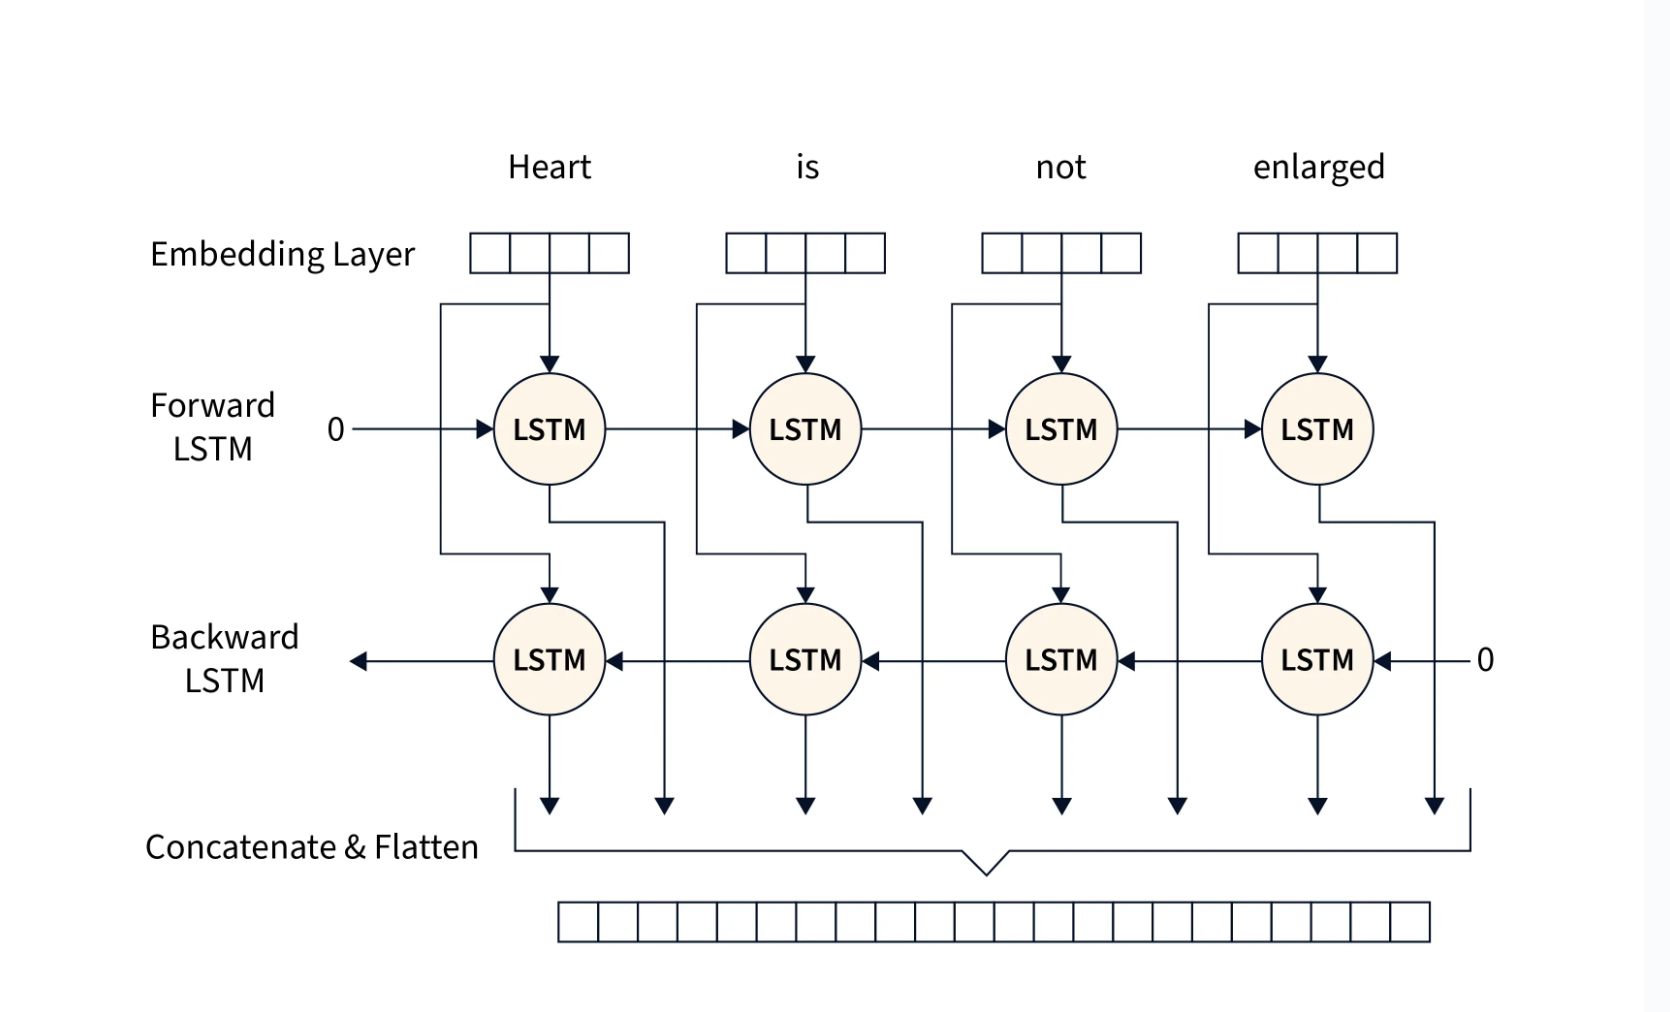

Như chúng ta biết, bối cảnh rất quan trọng khi lập mô hình dữ liệu tuần tự. Tuy nhiên, bối cảnh từ cả hai phía mới là vấn đề. Ví dụ: để xây dựng một mô hình điền vào các khoảng trống của chuỗi văn bản, chẳng hạn - các cậu bé là ______ môn cricket, tất cả bốn từ đều tạo thành thông tin ngữ cảnh để mô hình sử dụng trong khi dự đoán từ nào sẽ phù hợp với chỗ trống.

Trong khi LSTM chỉ có thể xử lý ngữ cảnh từ một hướng thì BiLSTM sử dụng hai LSTM trong một kiến trúc duy nhất để sử dụng ngữ cảnh từ cả hai phía của chuỗi.

### LSTM so với Bi-LSTM
Điểm khác biệt chính giữa LSTM so với Bi-LSTM là ở kiến ​​trúc của chúng cho phép Bi-LSTM sử dụng ngữ cảnh từ cả hai đầu theo một trình tự.

Cụ thể, LSTM một chiều có thể lưu giữ thông tin từ các đơn vị đầu vào đã đi qua nó bằng cách sử dụng trạng thái ẩn, tức là từ các bước thời gian trước đó.

Với LSTM hai chiều, chúng tôi chạy chuỗi đầu vào qua mạng theo hai cách sau khi chuỗi được xử lý như hiện tại. Khi trình tự đảo ngược được xử lý theo đó, chúng ta sẽ có được hai trạng thái ẩn kết hợp mà chúng ta có thể lưu giữ thông tin từ cả quá khứ và tương lai.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset


from sklearn.model_selection import train_test_split

import pandas as pd

df = pd.read_csv('MSFT.csv')

df

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [ ]:
df = df[['Date', 'Close']]
print(len(df))

8584


In [ ]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
8579    2020-03-26
8580    2020-03-27
8581    2020-03-30
8582    2020-03-31
8583    2020-04-01
Name: Date, Length: 8584, dtype: object

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
8579   2020-03-26
8580   2020-03-27
8581   2020-03-30
8582   2020-03-31
8583   2020-04-01
Name: Date, Length: 8584, dtype: datetime64[ns]

In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2020-03-26,156.110001
2020-03-27,149.699997
2020-03-30,160.229996


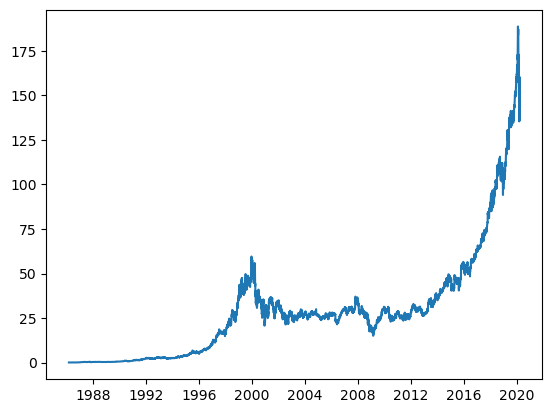

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=4):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '1998-02-03',
                                '2020-04-01',
                                n=4)
windowed_df

,Target Date,Target-4,Target-3,Target-2,Target-1,Target
0,1998-02-03,18.625000,18.531250,18.648438,19.359375,19.484375
1,1998-02-04,18.531250,18.648438,19.359375,19.484375,19.601562
2,1998-02-05,18.648438,19.359375,19.484375,19.601562,19.429688
3,1998-02-06,19.359375,19.484375,19.601562,19.429688,19.765625
4,1998-02-09,19.484375,19.601562,19.429688,19.765625,19.648438
...,...,...,...,...,...,...
5572,2020-03-26,137.350006,135.979996,148.339996,146.919998,156.110001
5573,2020-03-27,135.979996,148.339996,146.919998,156.110001,149.699997
5574,2020-03-30,148.339996,146.919998,156.110001,149.699997,160.229996
5575,2020-03-31,146.919998,156.110001,149.699997,160.229996,157.710007


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((5577,), (5577, 4, 1), (5577,))

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(y_train_tensor[0])

tensor(96.1100)


In [ ]:
class Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    # get item for each index
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # get len of dataset
    def __len__(self):
        return len(self.x)

In [ ]:
train_ds = Dataset(X_train_tensor, y_train_tensor.float())
test_ds = Dataset(X_test_tensor, y_test_tensor.float())

In [ ]:
print(train_ds)

In [ ]:
# Hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 10
input_size = 1
sequence_length = 1
num_layers = 2
hidden_size = 256
num_classes = 1

In [ ]:
# Load data to dataloader for batch processing
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)


In [ ]:
# Create a bidirectional LSTM model class
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out.squeeze()


In [ ]:
# Initialize the custom network
model = BiLSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Train Network
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        print(f"Epoch {epoch+1}, Step {batch_idx+1}, Loss: {loss / 100:.4f}")


Epoch 1, Step 1, Loss: 32.6307
Epoch 1, Step 2, Loss: 20.3089
Epoch 1, Step 3, Loss: 29.2341
Epoch 1, Step 4, Loss: 25.3078
Epoch 1, Step 5, Loss: 21.3174
Epoch 1, Step 6, Loss: 18.1576
Epoch 1, Step 7, Loss: 29.6591
Epoch 1, Step 8, Loss: 25.0183
Epoch 1, Step 9, Loss: 17.2671
Epoch 1, Step 10, Loss: 20.7608
Epoch 1, Step 11, Loss: 24.7257
Epoch 1, Step 12, Loss: 19.7860
Epoch 1, Step 13, Loss: 29.3383
Epoch 1, Step 14, Loss: 16.8952
Epoch 1, Step 15, Loss: 17.8703
Epoch 1, Step 16, Loss: 16.1266
Epoch 1, Step 17, Loss: 15.7144
Epoch 1, Step 18, Loss: 6.6607
Epoch 1, Step 19, Loss: 11.5339
Epoch 1, Step 20, Loss: 30.1653
Epoch 1, Step 21, Loss: 19.3460
Epoch 1, Step 22, Loss: 24.0078
Epoch 1, Step 23, Loss: 16.7178
Epoch 1, Step 24, Loss: 30.7537
Epoch 1, Step 25, Loss: 13.3295
Epoch 1, Step 26, Loss: 12.4296
Epoch 1, Step 27, Loss: 9.8491
Epoch 1, Step 28, Loss: 14.0423
Epoch 1, Step 29, Loss: 12.1422
Epoch 1, Step 30, Loss: 12.3304
Epoch 1, Step 31, Loss: 8.5668
Epoch 1, Step 32, Lo

Test Loss: 24.6585


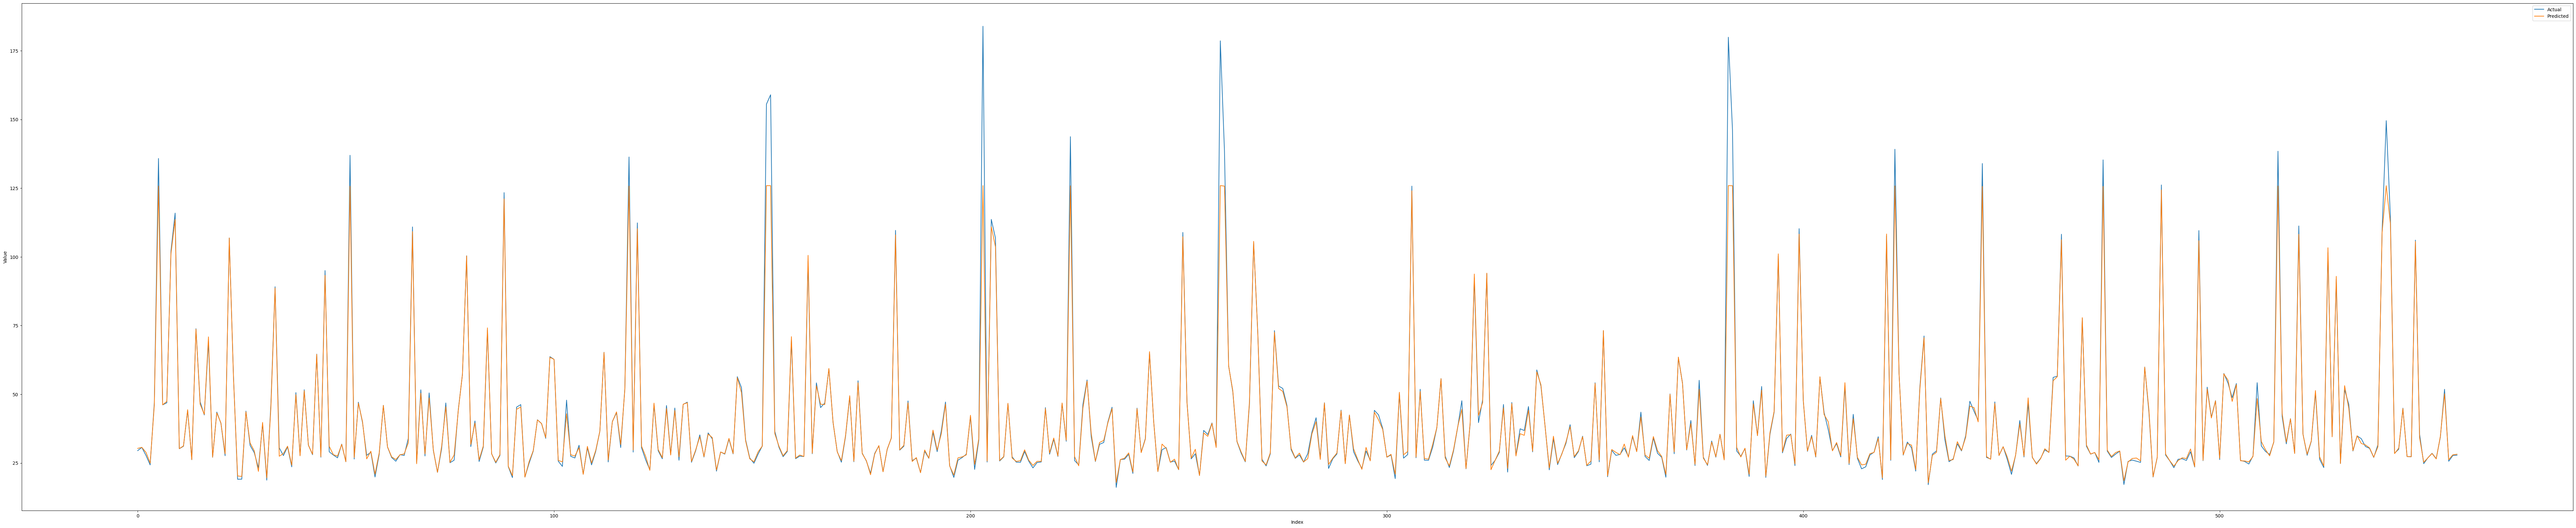

In [ ]:
import matplotlib.pyplot as plt
with torch.no_grad():
    model.eval()
    y_pred = model(X_test_tensor.to(device=device))
    test_loss = criterion(y_pred, y_test_tensor.to(device=device))
    print(f'Test Loss: {test_loss.item():.4f}')

     # Convert the tensors to numpy arrays
    y_test = y_test_tensor.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    plt.figure(figsize=(100, 20))

    # Plot the line graph
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### AirPassengers.csv

In [ ]:
df = pd.read_csv('AirPassengers.csv')

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
print(df['Month'])

0      1949-01
1      1949-02
2      1949-03
3      1949-04
4      1949-05
        ...   
139    1960-08
140    1960-09
141    1960-10
142    1960-11
143    1960-12
Name: Month, Length: 144, dtype: object


In [ ]:
df['Month'] = pd.to_datetime(df['Month'])

In [ ]:
df.set_index('Month', inplace=True) #set date as index

In [ ]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


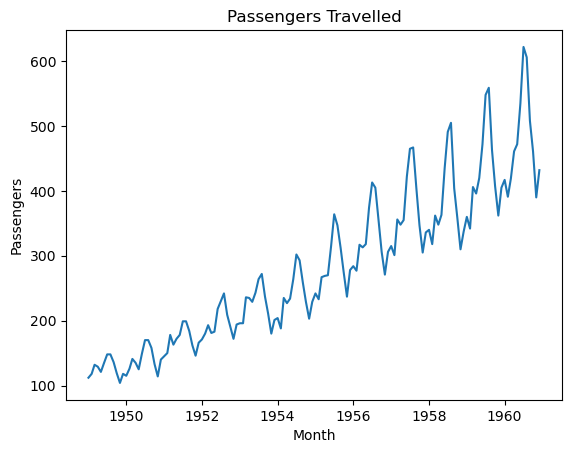

In [ ]:
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Passengers Travelled")
plt.plot(df['Passengers'],)

In [ ]:
df['Passengers']

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(df)

In [ ]:
#Creating train and test partition
train = int(len(data)*0.75)
test = len(data)-train
train_data,test_data=data[0:train,:],data[train:len(data),:1]

In [ ]:
# converting an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 4
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

y_train

array([0.03281853, 0.05984556, 0.08494208, 0.08494208, 0.06177606,
       0.02895753, 0.        , 0.02702703, 0.02123552, 0.04247104,
       0.07142857, 0.05984556, 0.04054054, 0.08687259, 0.12741313,
       0.12741313, 0.1042471 , 0.05598456, 0.01930502, 0.06949807,
       0.07915058, 0.08880309, 0.14285714, 0.11389961, 0.13127413,
       0.14285714, 0.18339768, 0.18339768, 0.15444015, 0.11196911,
       0.08108108, 0.11969112, 0.12934363, 0.14671815, 0.17181467,
       0.14864865, 0.15250965, 0.22007722, 0.24324324, 0.26640927,
       0.2027027 , 0.16795367, 0.13127413, 0.17374517, 0.17760618,
       0.17760618, 0.25482625, 0.25289575, 0.24131274, 0.26833977,
       0.30888031, 0.32432432, 0.25675676, 0.20656371, 0.14671815,
       0.18725869, 0.19305019, 0.16216216, 0.25289575, 0.23745174,
       0.25096525, 0.30888031, 0.38223938, 0.36486486, 0.2992278 ,
       0.24131274, 0.19111969, 0.24131274, 0.26640927, 0.24903475,
       0.31467181, 0.31853282, 0.32046332, 0.40733591, 0.50193

In [ ]:
X_train.shape, y_train.shape

((103, 4), (103,))

In [ ]:
print(X_train[3])
print(y_train[3])

[0.04826255 0.03281853 0.05984556 0.08494208]
0.08494208494208491


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
print(X_train_tensor[0])
print(y_test_tensor[0])

tensor([[0.0154],
        [0.0270],
        [0.0541],
        [0.0483]])
tensor(0.5000)


In [ ]:
train_ds = Dataset(X_train_tensor, y_train_tensor.float())
test_ds = Dataset(X_test_tensor, y_test_tensor.float())

In [ ]:
# Load data to dataloader for batch processing
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)


In [ ]:
# Hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 20
input_size = 1
sequence_length = 1
num_layers = 2
hidden_size = 256
num_classes = 1

In [ ]:
# Create a bidirectional LSTM model class
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out.squeeze()


In [ ]:
# Initialize the custom network
model = BiLSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Train Network
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        print(f"Epoch {epoch+1}, Step {batch_idx+1}, Loss: {loss / 100:.4f}")


Epoch 1, Step 1, Loss: 0.0010
Epoch 1, Step 2, Loss: 0.0004
Epoch 2, Step 1, Loss: 0.0003
Epoch 2, Step 2, Loss: 0.0003
Epoch 3, Step 1, Loss: 0.0003
Epoch 3, Step 2, Loss: 0.0003
Epoch 4, Step 1, Loss: 0.0003
Epoch 4, Step 2, Loss: 0.0003
Epoch 5, Step 1, Loss: 0.0002
Epoch 5, Step 2, Loss: 0.0002
Epoch 6, Step 1, Loss: 0.0003
Epoch 6, Step 2, Loss: 0.0001
Epoch 7, Step 1, Loss: 0.0002
Epoch 7, Step 2, Loss: 0.0003
Epoch 8, Step 1, Loss: 0.0002
Epoch 8, Step 2, Loss: 0.0003
Epoch 9, Step 1, Loss: 0.0002
Epoch 9, Step 2, Loss: 0.0002
Epoch 10, Step 1, Loss: 0.0002
Epoch 10, Step 2, Loss: 0.0002
Epoch 11, Step 1, Loss: 0.0002
Epoch 11, Step 2, Loss: 0.0002
Epoch 12, Step 1, Loss: 0.0002
Epoch 12, Step 2, Loss: 0.0002
Epoch 13, Step 1, Loss: 0.0002
Epoch 13, Step 2, Loss: 0.0001
Epoch 14, Step 1, Loss: 0.0001
Epoch 14, Step 2, Loss: 0.0001
Epoch 15, Step 1, Loss: 0.0002
Epoch 15, Step 2, Loss: 0.0001
Epoch 16, Step 1, Loss: 0.0001
Epoch 16, Step 2, Loss: 0.0001
Epoch 17, Step 1, Loss: 0.

In [ ]:
import matplotlib.pyplot as plt
with torch.no_grad():
    model.eval()
    y_pred = model(X_test_tensor.to(device=device))
    test_loss = criterion(y_pred, y_test_tensor.to(device=device))
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0307


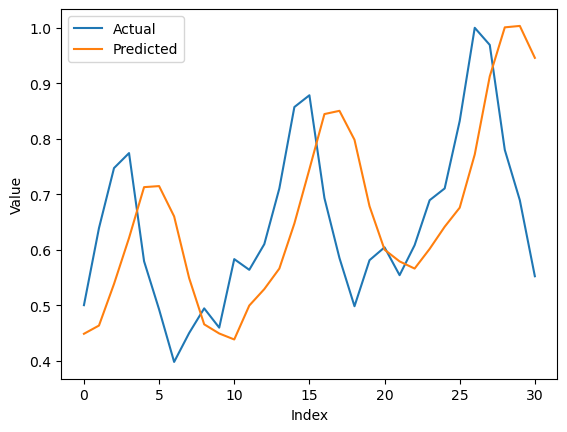

In [ ]:
y_test = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

# Plot the line graph
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()